## First of all I loaded all the data into Snowflake database for easier manipulation
I made a simple datamart with snap dates '2020-09-08' for training
and '2020-09-15' for testing, datamart was exported in one csv file named
model_build_base.csv

#### The train set contains following data:
* 259916 rows of SOLD=1 -> All transactions that were sold in week '2020-09-08' to '2020-09-15'
* 1000000 randomly chosen combinations of customer_id and article_id that were not sold that week with SOLD=0
* All article information, customer information and customer transaction history info is also joined

#### The test set contains following data:
* All the same as train set just shifted one week forward for week between '2020-09-15' and '2020-09-22'



#### Fitting
A simple XGBoost model was fitted


In [1]:
#importing custom library
!pip install git+https://github.com/Vrboska/mofr@master

  Cloning https://github.com/Vrboska/mofr (to revision master) to /tmp/pip-req-build-jm9f2gtd
  Running command git clone --filter=blob:none --quiet https://github.com/Vrboska/mofr /tmp/pip-req-build-jm9f2gtd
  Running command git checkout -b master --track origin/master
  Switched to a new branch 'master'
  Branch 'master' set up to track remote branch 'master' from 'origin'.
  Resolved https://github.com/Vrboska/mofr to commit 9e35370debae10d418189ddd58b213a64b210895
  Preparing metadata (setup.py) ... - done
  Created wheel for mofr: filename=mofr-1.0-py3-none-any.whl size=25810 sha256=4fc263f0633fdddbab4c58774e8ae2d0e5fcc1acdc5c7e471089d8133ae149bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-kcjpylt4/wheels/b8/d0/2a/36bf0097c9fa72bb9af2b201e9b71bbfa6ebbae4fc8d066dc7
Successfully built mofr


In [2]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error,mean_squared_error, mean_squared_log_error)
from xgboost import XGBClassifier, plot_tree
import math

import xgboost as xgb
import hyperopt

In [3]:
seed=1234

In [4]:
df=pd.read_csv('/kaggle/input/hm-model-build-base/model_build_base.csv').fillna(0)

In [5]:
len(df)

2496538

In [6]:
# #removing bads due to capacity issues (at the end we train with full data though)
# remove_n = 3000000
# drop_indices = np.random.choice(df[df['SOLD']==0].index, remove_n, replace=False)
# df = df.drop(drop_indices)
#len(df)

In [7]:
len(df)

2496538

In [8]:
del df['Unnamed: 0']

In [9]:
df.head()

,SOLD,SNAP_DATE,CUSTOMER_ID,ARTICLE_ID,ACTIVE,CLUB_MEMBER_STATUS,FASHION_NEWS_FREQUENCY,AGE,QUANT_PG_ACCESSORIES_1M,QUANT_PG_BAGS_1M,...,ART_DAYS_SINCE_LAST_PURCHASE,ART_AVERAGE_PRICE,ART_NUM_CHANNEL_2,CUSTART_QUANTITY_SOLD_1M,CUSTART_QUANTITY_SOLD_3M,CUSTART_QUANTITY_SOLD_12M,CUSTART_QUANTITY_SOLD_OVERALL,CUSTART_DAYS_SINCE_FIRST_PURCHASE,CUSTART_DAYS_SINCE_LAST_PURCHASE,CUSTART_NUM_CHANNEL_2
0,0,2020-09-08,640ff75e50449d9802ee64ec8aa45ebef47efcad440db2...,752120001,0.0,ACTIVE,NONE,28.0,0.0,0.0,...,73.0,0.015406,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2020-09-08,f123d3e4152ec30491588efd0973b279ca5657faf59175...,443078001,0.0,ACTIVE,NONE,62.0,0.0,0.0,...,223.0,0.062407,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2020-09-15,6abaa05af4ab4d0f50c704f461f16380b753a377e64d89...,609715002,0.0,ACTIVE,NONE,22.0,0.0,0.0,...,91.0,0.014561,410.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2020-09-08,b74fc608c2e166aa327fe118eca7fe9e372c18ce309101...,863646004,0.0,ACTIVE,NONE,24.0,1.0,0.0,...,0.0,0.033073,332.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2020-09-15,b9c3a816efc40a43817bb693950886899042922f92fe5b...,652731001,1.0,ACTIVE,Regularly,37.0,0.0,0.0,...,483.0,0.047568,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# df['CLUB_MEMBER_STATUS']=df['CLUB_MEMBER_STATUS'].replace(0, np.nan)
# df['FASHION_NEWS_FREQUENCY']=df['FASHION_NEWS_FREQUENCY'].replace(0, np.nan)

In [11]:
train_mask=df['SNAP_DATE']=='2020-09-08'
valid_mask=df['SNAP_DATE']=='2020-09-15'

In [12]:
df[train_mask]['SOLD'].value_counts()

0    1000000
1     259916
Name: SOLD, dtype: int64

In [13]:
df[valid_mask]['SOLD'].value_counts()

0    1000000
1     236622
Name: SOLD, dtype: int64

# Data Exploration

In [14]:
df[train_mask].describe()

,SOLD,ARTICLE_ID,ACTIVE,AGE,QUANT_PG_ACCESSORIES_1M,QUANT_PG_BAGS_1M,QUANT_PG_COSMETIC_1M,QUANT_PG_FUN_1M,QUANT_PG_FURNITURE_1M,QUANT_PG_GFB_1M,...,ART_DAYS_SINCE_LAST_PURCHASE,ART_AVERAGE_PRICE,ART_NUM_CHANNEL_2,CUSTART_QUANTITY_SOLD_1M,CUSTART_QUANTITY_SOLD_3M,CUSTART_QUANTITY_SOLD_12M,CUSTART_QUANTITY_SOLD_OVERALL,CUSTART_DAYS_SINCE_FIRST_PURCHASE,CUSTART_DAYS_SINCE_LAST_PURCHASE,CUSTART_NUM_CHANNEL_2
count,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1259916.0,1259916.0,1.259916e+06,...,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06,1.259916e+06
mean,2.062963e-01,7.217992e+08,4.484958e-01,3.545625e+01,1.678318e-01,2.387461e-03,1.190556e-05,0.0,0.0,4.321756e-01,...,1.838698e+02,2.871413e-02,3.985093e+02,3.434277e-02,3.594208e-02,3.908594e-02,4.087653e-02,1.067764e+00,8.045108e-01,3.059648e-02
std,4.046458e-01,1.363477e+08,4.973404e-01,1.408830e+01,6.600916e-01,5.218290e-02,3.450424e-03,0.0,0.0,1.682844e+00,...,2.225952e+02,2.499448e-02,1.479877e+03,2.245194e-01,2.340856e-01,2.592234e-01,2.821074e-01,2.049351e+01,1.699859e+01,2.408920e-01
min,0.000000e+00,1.087750e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,6.298970e+08,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,0.000000e+00,1.468379e-02,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,7.324090e+08,0.000000e+00,3.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,5.900000e+01,2.391933e-02,5.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,8.319430e+08,1.000000e+00,4.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,3.560000e+02,3.404733e-02,2.880000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,9.594610e+08,1.000000e+00,9.600000e+01,2.600000e+01,3.000000e+00,1.000000e+00,0.0,0.0,8.900000e+01,...,7.190000e+02,5.067797e-01,4.186300e+04,5.700000e+01,5.700000e+01,5.700000e+01,6.500000e+01,7.190000e+02,7.190000e+02,5.700000e+01


In [15]:
df[train_mask].describe(include=['O'])

,SNAP_DATE,CUSTOMER_ID,CLUB_MEMBER_STATUS,FASHION_NEWS_FREQUENCY,ART_PRODUCT_GROUP_NAME,COLOUR,ART_PERCEIVED_COLOUR,ART_INDEX_CODE
count,1259916,1259916,1259916,1259916,1259916,1259916,1259916,1259916
unique,1,80765,4,4,19,12,8,10
top,2020-09-08,e7cd5bad25c91d7922ee15ab487f03714177f6b0fd275f...,ACTIVE,NONE,Garment Upper body,BLACK,Dark,A
freq,1259916,62,1244110,682044,531802,309281,527709,366959


# Data transformations

In [16]:
col_target='SOLD'
col_exclude=[
'SNAP_DATE',
'CUSTOMER_ID',
'ARTICLE_ID',

col_target,
    

]+[col for col in df.columns if 'CUSTART' in col]

In [17]:
col_exclude

['SNAP_DATE',
 'CUSTOMER_ID',
 'ARTICLE_ID',
 'SOLD',
 'CUSTART_QUANTITY_SOLD_1M',
 'CUSTART_QUANTITY_SOLD_3M',
 'CUSTART_QUANTITY_SOLD_12M',
 'CUSTART_QUANTITY_SOLD_OVERALL',
 'CUSTART_DAYS_SINCE_FIRST_PURCHASE',
 'CUSTART_DAYS_SINCE_LAST_PURCHASE',
 'CUSTART_NUM_CHANNEL_2']

## Categorical transformations

In [18]:
import category_encoders as ce

In [19]:
# potential predictors without encoding
cat_preds = [col for col in df.select_dtypes(include="object") if col not in col_exclude]
bool_preds = [col for col in df.select_dtypes(include="bool") if col not in col_exclude]
datetime_preds = [col for col in df.select_dtypes(include="datetime") if col not in col_exclude]

In [20]:
cat_preds

['CLUB_MEMBER_STATUS',
 'FASHION_NEWS_FREQUENCY',
 'ART_PRODUCT_GROUP_NAME',
 'COLOUR',
 'ART_PERCEIVED_COLOUR',
 'ART_INDEX_CODE']

### Target Encoding

In [21]:
# # bayesian target encoding
encoder = ce.TargetEncoder(min_samples_leaf=1, smoothing=1.0)
encoder.fit_transform(df[train_mask][cat_preds], df[train_mask][col_target])

df = pd.concat([df, encoder.transform(df[cat_preds]).add_prefix("BAYES_")], axis=1)

/opt/conda/lib/python3.7/site-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [22]:
col_preds=[col for col in df.select_dtypes(include=["int","float"]) if col not in col_exclude]

In [23]:
len(col_preds)

88

# Fitting models

In [24]:
(df[train_mask][col_target]>0).value_counts(normalize=True)

False    0.793704
True     0.206296
Name: SOLD, dtype: float64

## XGBoost model

In [25]:
xgb_model = XGBClassifier(max_depth=4, seed=seed, colsample_bytree=1, gamma=1, min_child_weight=5, n_estimators=100)
xgb_model.fit(df[train_mask].loc[:, col_preds], df[train_mask][col_target], verbose=0, eval_metric='logloss')


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1234, reg_alpha=0, reg_lambda=1, ...)

In [26]:
df['XGB_SCORE']=xgb_model.predict_proba(df[col_preds])[:, 1]

In [27]:
print('The Lift on the train set is: '+ str(mofr.metrics.lift(df[train_mask][col_target], df[train_mask]['XGB_SCORE'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(df[train_mask][col_target], df[train_mask]['XGB_SCORE'])))
print('The accuracy on the train set is: '+ str(mofr.metrics.accuracy_score(df[train_mask][col_target], df[train_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
print('\n')
print('The Lift on the valid set is: '+ str(mofr.metrics.lift(df[valid_mask][col_target], df[valid_mask]['XGB_SCORE'])))
print('The gini on the valid set is: '+ str(mofr.metrics.gini(df[valid_mask][col_target], df[valid_mask]['XGB_SCORE'])))
print('The accuracy on the valid set is: '+ str(mofr.metrics.accuracy_score(df[valid_mask][col_target], df[valid_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))

The Lift on the train set is: 4.53810560035763
The gini on the train set is: 0.9480413227311901
The accuracy on the train set is: 0.9279245600500351


The Lift on the valid set is: 4.786337167503749
The gini on the valid set is: 0.9456096071371216
The accuracy on the valid set is: 0.9277879578399867


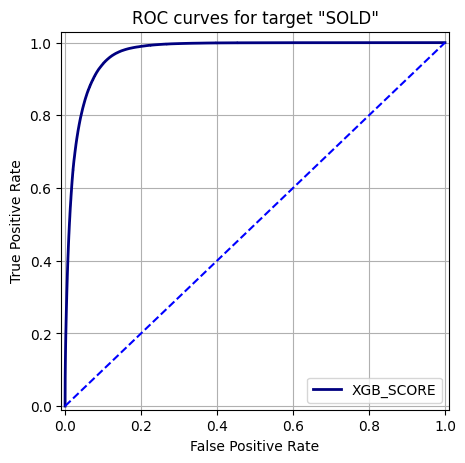

In [28]:
from mofr.basic_evaluators.ROCCurve import ROCCurveEvaluator
df['one']=1

rce=ROCCurveEvaluator()
rce.d(df[valid_mask]).t([(col_target,'one')]).s(['XGB_SCORE'])
rce.get_graph()

del df['one']

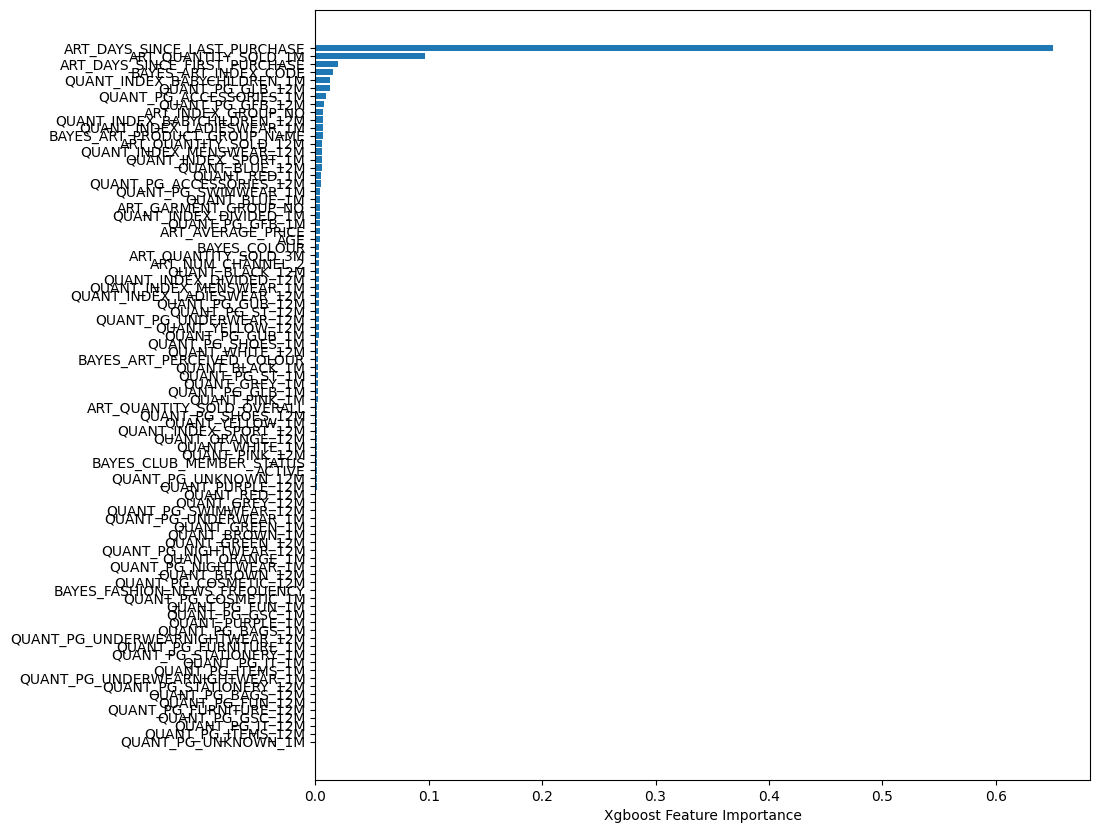

In [29]:
sorted_idx = xgb_model.feature_importances_.argsort()
order_ = []
for i in sorted_idx:
  order_.append(col_preds[i])
plt.figure(figsize=(10, 10))
fig = plt.barh(order_, xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [30]:
# results=[]
# for col in col_preds:
#     results.append((col, np.abs(mofr.metrics.gini(df[valid_mask][col_target], df[valid_mask][col]))))
  
# pd.DataFrame(results, columns=['Predictor', 'GINI']).sort_values(by='GINI', ascending=False)[0:30]

### Saving the model

In [31]:
import pickle
file_name = "hm_xgb_model.pkl"

# save
pickle.dump(xgb_model, open(file_name, "wb"))

# # load
# #xgb_model= pickle.load(open(file_name, "rb"))

In [32]:
import pickle
file_name = "hm_encoder.pkl"

# save
pickle.dump(encoder, open(file_name, "wb"))

# # load
# #encoder = pickle.load(open(file_name, "rb"))

# Additional checks

In [33]:
df.head()

,SOLD,SNAP_DATE,CUSTOMER_ID,ARTICLE_ID,ACTIVE,CLUB_MEMBER_STATUS,FASHION_NEWS_FREQUENCY,AGE,QUANT_PG_ACCESSORIES_1M,QUANT_PG_BAGS_1M,...,CUSTART_DAYS_SINCE_FIRST_PURCHASE,CUSTART_DAYS_SINCE_LAST_PURCHASE,CUSTART_NUM_CHANNEL_2,BAYES_CLUB_MEMBER_STATUS,BAYES_FASHION_NEWS_FREQUENCY,BAYES_ART_PRODUCT_GROUP_NAME,BAYES_COLOUR,BAYES_ART_PERCEIVED_COLOUR,BAYES_ART_INDEX_CODE,XGB_SCORE
0,0,2020-09-08,640ff75e50449d9802ee64ec8aa45ebef47efcad440db2...,752120001,0.0,ACTIVE,NONE,28.0,0.0,0.0,...,0.0,0.0,0.0,0.206562,0.208981,0.108735,0.261318,0.095471,0.182325,0.002735
1,0,2020-09-08,f123d3e4152ec30491588efd0973b279ca5657faf59175...,443078001,0.0,ACTIVE,NONE,62.0,0.0,0.0,...,0.0,0.0,0.0,0.206562,0.208981,0.238907,0.214769,0.163729,0.115690,0.000330
2,0,2020-09-15,6abaa05af4ab4d0f50c704f461f16380b753a377e64d89...,609715002,0.0,ACTIVE,NONE,22.0,0.0,0.0,...,0.0,0.0,0.0,0.206562,0.208981,0.116441,0.124399,0.163729,0.306366,0.000396
3,1,2020-09-08,b74fc608c2e166aa327fe118eca7fe9e372c18ce309101...,863646004,0.0,ACTIVE,NONE,24.0,1.0,0.0,...,0.0,0.0,0.0,0.206562,0.208981,0.238907,0.261318,0.216554,0.329083,0.948716
4,0,2020-09-15,b9c3a816efc40a43817bb693950886899042922f92fe5b...,652731001,1.0,ACTIVE,Regularly,37.0,0.0,0.0,...,0.0,0.0,0.0,0.206562,0.203330,0.233927,0.305091,0.233187,0.329083,0.000113


## Categorical encoding check

## SHAP values

In [34]:
import shap  # package used to calculate Shap values

In [35]:
row_to_show = 1
data_for_prediction = df[train_mask][col_preds].iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [36]:
# shap_values = explainer.shap_values(df[train_mask][col_preds])
# shap.summary_plot(shap_values, df[train_mask][col_preds])

# Future predictions part

Simple article preselection approach was chosen-> top 1000 articles by average XGB_SCORE 

In [37]:
del df

In [38]:
# import pickle
# file_name1= "hm_xgb_model.pkl"
# file_name2= "hm_encoder.pkl"

# # load
# xgb_model= pickle.load(open(file_name1, "rb"))
# encoder= pickle.load(open(file_name2, "rb"))

In [39]:
articles=pd.read_csv('/kaggle/input/hm-model-build-base/articles_predictions.csv')
customers=pd.read_csv('/kaggle/input/hm-model-build-base/customers_prediction.csv')

In [40]:
del customers['Unnamed: 0']

In [41]:
customers['CUSTOMER_ID10']=customers['CUSTOMER_ID'].apply(lambda x: x[0:10])

## Scoring customers in batches to produce submission file
For each of the 1000 suggested items and for each customer, then ordering and picking top 12

In [42]:
submission=pd.DataFrame()

In [43]:
def process_chunk(chunk):
    chunk=chunk.rename(columns={'CUSTOMER_ID':'CUSTOMER_ID10'})
    chunk=chunk.merge(articles, how='left', on='ARTICLE_ID')
    chunk=chunk.merge(customers, how='left', left_on='CUSTOMER_ID10', right_on='CUSTOMER_ID10')
    chunk = pd.concat([chunk, encoder.transform(chunk[cat_preds]).add_prefix("BAYES_")], axis=1)
    
    chunk['XGB_SCORE']=xgb_model.predict_proba(chunk[xgb_model.feature_names_in_])[:, 1]
    chunk['ARTICLE_ID']=chunk['ARTICLE_ID'].apply(str).apply(lambda x: x.zfill(10))
    a=chunk[['CUSTOMER_ID', 'ARTICLE_ID', 'XGB_SCORE']].groupby('CUSTOMER_ID').apply(lambda x : x.sort_values(by = 'XGB_SCORE', ascending = False).head(12).reset_index(drop = True)).reset_index(drop = True)
    b=pd.DataFrame(a.groupby('CUSTOMER_ID')['ARTICLE_ID'].apply(list).apply(' '.join)).reset_index(drop=False).rename(columns={'ARTICLE_ID':'PREDICTION'})
    return b

In [44]:
n=0
chunksize = 10 ** 6
with pd.read_csv('/kaggle/input/hm-model-build-base/model_suggested_items.csv', chunksize=chunksize) as reader:
    for chunk in reader:
        print(f'{n}: {round(n/3.94,2)} % done')
        submission=pd.concat([submission,process_chunk(chunk)])
        n+=1

0: 0.0 % done
1: 0.25 % done
2: 0.51 % done
3: 0.76 % done
4: 1.02 % done
5: 1.27 % done
6: 1.52 % done
7: 1.78 % done
8: 2.03 % done
9: 2.28 % done
10: 2.54 % done
11: 2.79 % done
12: 3.05 % done
13: 3.3 % done
14: 3.55 % done
15: 3.81 % done
16: 4.06 % done
17: 4.31 % done
18: 4.57 % done
19: 4.82 % done
20: 5.08 % done
21: 5.33 % done
22: 5.58 % done
23: 5.84 % done
24: 6.09 % done
25: 6.35 % done
26: 6.6 % done
27: 6.85 % done
28: 7.11 % done
29: 7.36 % done
30: 7.61 % done
31: 7.87 % done
32: 8.12 % done
33: 8.38 % done
34: 8.63 % done
35: 8.88 % done
36: 9.14 % done
37: 9.39 % done
38: 9.64 % done
39: 9.9 % done
40: 10.15 % done
41: 10.41 % done
42: 10.66 % done
43: 10.91 % done
44: 11.17 % done
45: 11.42 % done
46: 11.68 % done
47: 11.93 % done
48: 12.18 % done
49: 12.44 % done
50: 12.69 % done
51: 12.94 % done
52: 13.2 % done
53: 13.45 % done
54: 13.71 % done
55: 13.96 % done
56: 14.21 % done
57: 14.47 % done
58: 14.72 % done
59: 14.97 % done
60: 15.23 % done
61: 15.48 % done
6

In [45]:
submission.drop_duplicates(subset='CUSTOMER_ID',keep='first', inplace=True, ignore_index=False)

In [46]:
submission.to_csv('submission.csv', index=False)